##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer learning with TensorFlow Hub

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

[TensorFlow Hub](http://tensorflow.org/hub) is a way to share pretrained model components. See the [TensorFlow Module Hub](https://tfhub.dev/) for a searchable listing of pre-trained models. This tutorial demonstrates:

1. How to use TensorFlow Hub with `tf.keras`.
1. How to do image classification using TensorFlow Hub.
1. How to do simple transfer learning.

## Setup

In [2]:
import matplotlib.pylab as plt

import tensorflow as tf

In [3]:
!pip install -q -U tf-hub-nightly
!pip install -q tfds-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


## An ImageNet classifier

### Download the classifier

Use `hub.module` to load a mobilenet, and `tf.keras.layers.Lambda` to wrap it up as a keras layer. Any [TensorFlow 2 compatible image classifier URL](https://tfhub.dev/s?q=tf2&module-type=image-classification) from tfhub.dev will work here.

In [4]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [5]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

### Run it on a single image

Download a single image to try the model on.

 8192/61306 [===>..........................] - ETA: 0s

65536/61306 [================================] - 0s 0us/step


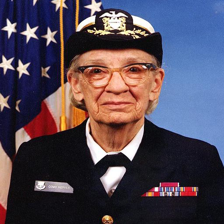

In [6]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [7]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension, and pass the image to the model.

In [8]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax:

In [9]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### Decode the predictions

We have the predicted class ID,
Fetch the `ImageNet` labels, and decode the predictions

In [10]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

 8192/10484 [======================>.......] - ETA: 0s

16384/10484 [==============================================] - 0s 0us/step


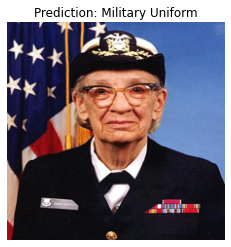

In [11]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Simple transfer learning

Using TF Hub it is simple to retrain the top layer of the model to recognize the classes in our dataset.

### Dataset

 For this example you will use the TensorFlow flowers dataset:

In [12]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

     8192/228813984 [..............................] - ETA: 4s

  5578752/228813984 [..............................] - ETA: 2s

 11198464/228813984 [>.............................] - ETA: 1s

 16785408/228813984 [=>............................] - ETA: 9s

 30646272/228813984 [===>..........................] - ETA: 4s

 44507136/228813984 [====>.........................] - ETA: 3s

 58187776/228813984 [======>.......................] - ETA: 2s

 72728576/228813984 [========>.....................] - ETA: 1s

 86949888/228813984 [==========>...................] - ETA: 1s

101113856/228813984 [============>.................] - ETA: 1s

115195904/228813984 [==============>...............] - ETA: 1s

117448704/228813984 [==============>...............] - ETA: 1s

132030464/228813984 [================>.............] - ETA: 1s

147914752/228813984 [==================>...........] - ETA: 0s

164085760/228813984 [====================>.........] - ETA: 0s

179748864/228813984 [======================>.......] - ETA: 0s

192946176/228813984 [========================>.....] - ETA: 0s

208125952/228813984 [==========================>...] - ETA: 0s

223707136/228813984 [============================>.] - ETA: 0s

228818944/228813984 [==============================] - 2s 0us/step


The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`,

All of TensorFlow Hub's image modules expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this.

The image size will be handled later.

In [13]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


The resulting object is an iterator that returns `image_batch, label_batch` pairs.

In [14]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


### Run the classifier on a batch of images

Now run the classifier on the image batch.

In [15]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [16]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['pot', 'picket fence', 'conch', 'daisy', 'cardoon', 'feather boa',
       'pot', 'sea urchin', 'broom', 'daisy', 'chickadee', 'volcano',
       'porcupine', 'picket fence', 'mushroom',
       'sulphur-crested cockatoo', 'daisy', 'vestment', 'hip',
       'sea urchin', 'buckeye', 'Bedlington terrier', 'sea urchin',
       'daisy', 'daisy', 'daisy', 'picket fence', 'matchstick', 'snail',
       'daisy', 'daisy', 'sea urchin'], dtype='<U30')

Now check how these predictions line up with the images:

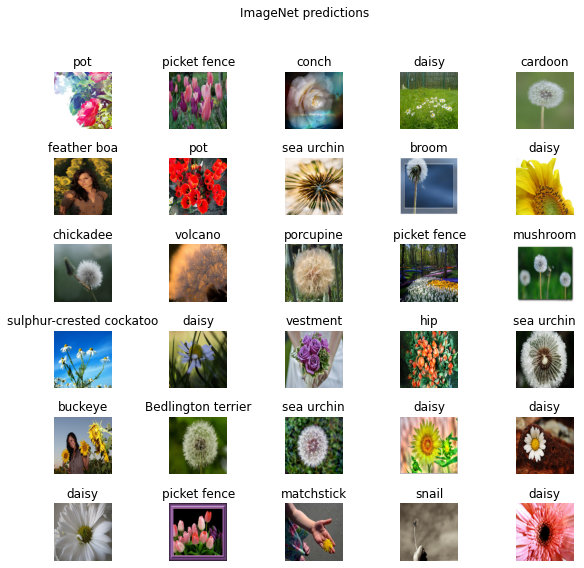

In [17]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

See the `LICENSE.txt` file for image attributions.

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except "daisy").

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [Tensorflow 2 compatible image feature vector URL](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev will work here.

In [18]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

Create the feature extractor.

In [19]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

It returns a 1280-length vector for each image:

In [20]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [21]:
feature_extractor_layer.trainable = False

### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [22]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
predictions = model(image_batch)

In [24]:
predictions.shape

TensorShape([32, 5])

### Train the model

Use compile to configure the training process:

In [25]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

Now use the `.fit` method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [26]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [27]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/2


  1/115 [..............................] - ETA: 0s - loss: 2.1563 - acc: 0.1875

  2/115 [..............................] - ETA: 6s - loss: 2.0655 - acc: 0.1250

  3/115 [..............................] - ETA: 8s - loss: 2.0512 - acc: 0.0625

  4/115 [>.............................] - ETA: 10s - loss: 1.6037 - acc: 0.3125

  5/115 [>.............................] - ETA: 10s - loss: 1.8810 - acc: 0.2812

  6/115 [>.............................] - ETA: 10s - loss: 1.9250 - acc: 0.1562

  7/115 [>.............................] - ETA: 10s - loss: 1.6587 - acc: 0.2812

  8/115 [=>............................] - ETA: 10s - loss: 1.5943 - acc: 0.4688

  9/115 [=>............................] - ETA: 10s - loss: 1.6103 - acc: 0.4375

 10/115 [=>............................] - ETA: 10s - loss: 1.1050 - acc: 0.5625

 11/115 [=>............................] - ETA: 10s - loss: 1.1148 - acc: 0.6250

 12/115 [==>...........................] - ETA: 10s - loss: 1.3052 - acc: 0.5625

 13/115 [==>...........................] - ETA: 9s - loss: 1.2646 - acc: 0.5000 

 14/115 [==>...........................] - ETA: 9s - loss: 1.2898 - acc: 0.5312

 15/115 [==>...........................] - ETA: 9s - loss: 1.0658 - acc: 0.6250

 16/115 [===>..........................] - ETA: 9s - loss: 0.8923 - acc: 0.6875

 17/115 [===>..........................] - ETA: 9s - loss: 0.9892 - acc: 0.6562

 18/115 [===>..........................] - ETA: 9s - loss: 0.9335 - acc: 0.6875

 19/115 [===>..........................] - ETA: 9s - loss: 0.7795 - acc: 0.7500

 20/115 [====>.........................] - ETA: 9s - loss: 0.7641 - acc: 0.7188

 21/115 [====>.........................] - ETA: 9s - loss: 0.7670 - acc: 0.8750

 22/115 [====>.........................] - ETA: 9s - loss: 0.7450 - acc: 0.7188

 23/115 [=====>........................] - ETA: 9s - loss: 0.7911 - acc: 0.7812

 24/115 [=====>........................] - ETA: 9s - loss: 0.8832 - acc: 0.7812

 25/115 [=====>........................] - ETA: 8s - loss: 0.8947 - acc: 0.7500

 26/115 [=====>........................] - ETA: 8s - loss: 0.8250 - acc: 0.6875

 27/115 [======>.......................] - ETA: 8s - loss: 0.8204 - acc: 0.8438

 28/115 [======>.......................] - ETA: 8s - loss: 0.8039 - acc: 0.8125

 29/115 [======>.......................] - ETA: 8s - loss: 0.8277 - acc: 0.7812

 30/115 [======>.......................] - ETA: 8s - loss: 0.5968 - acc: 0.8750

 31/115 [=======>......................] - ETA: 8s - loss: 0.6731 - acc: 0.7500

 32/115 [=======>......................] - ETA: 8s - loss: 0.7217 - acc: 0.7188

 33/115 [=======>......................] - ETA: 8s - loss: 0.8785 - acc: 0.7188

 34/115 [=======>......................] - ETA: 7s - loss: 0.8593 - acc: 0.6562

 35/115 [========>.....................] - ETA: 7s - loss: 0.6526 - acc: 0.8438

 36/115 [========>.....................] - ETA: 7s - loss: 0.6632 - acc: 0.7500

 37/115 [========>.....................] - ETA: 7s - loss: 0.7464 - acc: 0.7500

 38/115 [========>.....................] - ETA: 7s - loss: 0.6515 - acc: 0.7500

 39/115 [=========>....................] - ETA: 7s - loss: 0.7004 - acc: 0.7500

 40/115 [=========>....................] - ETA: 7s - loss: 0.7268 - acc: 0.7188

 41/115 [=========>....................] - ETA: 7s - loss: 0.5544 - acc: 0.8125

 42/115 [=========>....................] - ETA: 7s - loss: 0.6618 - acc: 0.8438

 43/115 [==========>...................] - ETA: 7s - loss: 0.6768 - acc: 0.7188

 44/115 [==========>...................] - ETA: 7s - loss: 0.6157 - acc: 0.7812

 45/115 [==========>...................] - ETA: 7s - loss: 0.4804 - acc: 0.8750

 46/115 [===========>..................] - ETA: 6s - loss: 0.4994 - acc: 0.8438

 47/115 [===========>..................] - ETA: 6s - loss: 0.8148 - acc: 0.7812

 48/115 [===========>..................] - ETA: 6s - loss: 0.5977 - acc: 0.8125

 49/115 [===========>..................] - ETA: 6s - loss: 0.5223 - acc: 0.8438

 50/115 [============>.................] - ETA: 6s - loss: 0.5418 - acc: 0.8438

 51/115 [============>.................] - ETA: 6s - loss: 0.5226 - acc: 0.8438

 52/115 [============>.................] - ETA: 6s - loss: 0.4690 - acc: 0.8750

 53/115 [============>.................] - ETA: 6s - loss: 0.4596 - acc: 0.9062

 54/115 [=============>................] - ETA: 6s - loss: 0.5131 - acc: 0.8125

 55/115 [=============>................] - ETA: 6s - loss: 0.7199 - acc: 0.7188

 56/115 [=============>................] - ETA: 5s - loss: 0.4861 - acc: 0.8438

 57/115 [=============>................] - ETA: 5s - loss: 0.5730 - acc: 0.7500

 58/115 [==============>...............] - ETA: 5s - loss: 0.5128 - acc: 0.8438

 59/115 [==============>...............] - ETA: 5s - loss: 0.3930 - acc: 0.8750

 60/115 [==============>...............] - ETA: 5s - loss: 0.5175 - acc: 0.8125

 61/115 [==============>...............] - ETA: 5s - loss: 0.4468 - acc: 0.8438

 62/115 [===============>..............] - ETA: 5s - loss: 0.3303 - acc: 0.9062

 63/115 [===============>..............] - ETA: 5s - loss: 0.5946 - acc: 0.8125

 64/115 [===============>..............] - ETA: 5s - loss: 0.4049 - acc: 0.8438

 65/115 [===============>..............] - ETA: 5s - loss: 0.7050 - acc: 0.7812

 66/115 [================>.............] - ETA: 4s - loss: 0.5339 - acc: 0.8125

 67/115 [================>.............] - ETA: 4s - loss: 0.3448 - acc: 0.9375

 68/115 [================>.............] - ETA: 4s - loss: 0.3926 - acc: 0.8750

 69/115 [=================>............] - ETA: 4s - loss: 0.5918 - acc: 0.8125

 70/115 [=================>............] - ETA: 4s - loss: 0.3745 - acc: 0.8438

 71/115 [=================>............] - ETA: 4s - loss: 0.3182 - acc: 0.9062

 72/115 [=================>............] - ETA: 4s - loss: 0.5667 - acc: 0.7812

 73/115 [==================>...........] - ETA: 4s - loss: 0.6818 - acc: 0.7500

 74/115 [==================>...........] - ETA: 4s - loss: 0.4936 - acc: 0.7812

 75/115 [==================>...........] - ETA: 3s - loss: 0.2989 - acc: 0.9375

 76/115 [==================>...........] - ETA: 3s - loss: 0.4989 - acc: 0.8750

 77/115 [===================>..........] - ETA: 3s - loss: 0.5338 - acc: 0.8438

 78/115 [===================>..........] - ETA: 3s - loss: 0.5018 - acc: 0.8438

 79/115 [===================>..........] - ETA: 3s - loss: 0.3336 - acc: 0.8750

 80/115 [===================>..........] - ETA: 3s - loss: 0.8691 - acc: 0.6250

 81/115 [====================>.........] - ETA: 3s - loss: 0.3387 - acc: 0.9375

 82/115 [====================>.........] - ETA: 3s - loss: 0.6048 - acc: 0.7812

 83/115 [====================>.........] - ETA: 3s - loss: 0.6073 - acc: 0.8750

 84/115 [====================>.........] - ETA: 3s - loss: 0.4954 - acc: 0.8125

 85/115 [=====================>........] - ETA: 2s - loss: 0.4046 - acc: 0.8750

 86/115 [=====================>........] - ETA: 2s - loss: 0.5008 - acc: 0.8125

 87/115 [=====================>........] - ETA: 2s - loss: 0.4917 - acc: 0.8438

 88/115 [=====================>........] - ETA: 2s - loss: 0.4900 - acc: 0.8438

 89/115 [======================>.......] - ETA: 2s - loss: 0.3258 - acc: 0.9375

 90/115 [======================>.......] - ETA: 2s - loss: 0.6440 - acc: 0.7188

 91/115 [======================>.......] - ETA: 2s - loss: 0.2137 - acc: 0.9545

 93/115 [=======================>......] - ETA: 2s - loss: 0.3304 - acc: 0.9062

 94/115 [=======================>......] - ETA: 2s - loss: 0.3643 - acc: 0.9375

 95/115 [=======================>......] - ETA: 1s - loss: 0.6052 - acc: 0.7812

 96/115 [========================>.....] - ETA: 1s - loss: 0.3826 - acc: 0.9062

 97/115 [========================>.....] - ETA: 1s - loss: 0.4048 - acc: 0.8125

 98/115 [========================>.....] - ETA: 1s - loss: 0.3250 - acc: 0.9375

 99/115 [========================>.....] - ETA: 1s - loss: 0.2907 - acc: 0.9375

100/115 [=========================>....] - ETA: 1s - loss: 0.6413 - acc: 0.7812

101/115 [=========================>....] - ETA: 1s - loss: 0.4473 - acc: 0.8750

102/115 [=========================>....] - ETA: 1s - loss: 0.5255 - acc: 0.8125

103/115 [=========================>....] - ETA: 1s - loss: 0.4644 - acc: 0.9062

104/115 [==========================>...] - ETA: 1s - loss: 0.3971 - acc: 0.9062

105/115 [==========================>...] - ETA: 0s - loss: 0.3177 - acc: 0.9375

106/115 [==========================>...] - ETA: 0s - loss: 0.4853 - acc: 0.8750

107/115 [==========================>...] - ETA: 0s - loss: 0.5527 - acc: 0.8125

108/115 [===========================>..] - ETA: 0s - loss: 0.3999 - acc: 0.8438

109/115 [===========================>..] - ETA: 0s - loss: 0.2953 - acc: 0.8750

110/115 [===========================>..] - ETA: 0s - loss: 0.4231 - acc: 0.8438

111/115 [===========================>..] - ETA: 0s - loss: 0.7025 - acc: 0.8125

112/115 [============================>.] - ETA: 0s - loss: 0.3183 - acc: 0.9375

113/115 [============================>.] - ETA: 0s - loss: 0.5783 - acc: 0.7812

114/115 [============================>.] - ETA: 0s - loss: 0.3309 - acc: 0.9375

115/115 [==============================] - ETA: 0s - loss: 0.4210 - acc: 0.8438

115/115 [==============================] - 11s 100ms/step - loss: 0.4210 - acc: 0.8438


Epoch 2/2


  1/115 [..............................] - ETA: 0s - loss: 0.3947 - acc: 0.8750

  2/115 [..............................] - ETA: 6s - loss: 0.2950 - acc: 0.9375

  3/115 [..............................] - ETA: 7s - loss: 0.3143 - acc: 0.9375

  4/115 [>.............................] - ETA: 8s - loss: 0.5286 - acc: 0.7500

  5/115 [>.............................] - ETA: 9s - loss: 0.4305 - acc: 0.8438

  6/115 [>.............................] - ETA: 9s - loss: 0.4881 - acc: 0.8125

  7/115 [>.............................] - ETA: 9s - loss: 0.4428 - acc: 0.8438

  8/115 [=>............................] - ETA: 9s - loss: 0.3538 - acc: 0.8125

  9/115 [=>............................] - ETA: 9s - loss: 0.4336 - acc: 0.8438

 10/115 [=>............................] - ETA: 9s - loss: 0.2697 - acc: 0.9375

 11/115 [=>............................] - ETA: 9s - loss: 0.2979 - acc: 0.9091

 12/115 [==>...........................] - ETA: 9s - loss: 0.2668 - acc: 0.9062

 13/115 [==>...........................] - ETA: 9s - loss: 0.4302 - acc: 0.8438

 14/115 [==>...........................] - ETA: 9s - loss: 0.3413 - acc: 0.8750

 15/115 [==>...........................] - ETA: 9s - loss: 0.2555 - acc: 0.9375

 16/115 [===>..........................] - ETA: 9s - loss: 0.3281 - acc: 0.9062

 17/115 [===>..........................] - ETA: 9s - loss: 0.2953 - acc: 0.9062

 18/115 [===>..........................] - ETA: 9s - loss: 0.2433 - acc: 0.9062

 19/115 [===>..........................] - ETA: 9s - loss: 0.5942 - acc: 0.8125

 20/115 [====>.........................] - ETA: 9s - loss: 0.3786 - acc: 0.8438

 21/115 [====>.........................] - ETA: 8s - loss: 0.4370 - acc: 0.8438

 22/115 [====>.........................] - ETA: 8s - loss: 0.2406 - acc: 0.9375

 23/115 [=====>........................] - ETA: 8s - loss: 0.2848 - acc: 0.9375

 24/115 [=====>........................] - ETA: 8s - loss: 0.1734 - acc: 0.9688

 25/115 [=====>........................] - ETA: 8s - loss: 0.5565 - acc: 0.7500

 26/115 [=====>........................] - ETA: 8s - loss: 0.2923 - acc: 0.8750

 27/115 [======>.......................] - ETA: 8s - loss: 0.2054 - acc: 0.9375

 28/115 [======>.......................] - ETA: 8s - loss: 0.2876 - acc: 0.9688

 29/115 [======>.......................] - ETA: 8s - loss: 0.4443 - acc: 0.7812

 30/115 [======>.......................] - ETA: 8s - loss: 0.3238 - acc: 0.8438

 31/115 [=======>......................] - ETA: 8s - loss: 0.3850 - acc: 0.8750

 32/115 [=======>......................] - ETA: 8s - loss: 0.3577 - acc: 0.8750

 33/115 [=======>......................] - ETA: 8s - loss: 0.2595 - acc: 0.9375

 34/115 [=======>......................] - ETA: 7s - loss: 0.4668 - acc: 0.8125

 35/115 [========>.....................] - ETA: 7s - loss: 0.3607 - acc: 0.8438

 36/115 [========>.....................] - ETA: 7s - loss: 0.2414 - acc: 0.9375

 37/115 [========>.....................] - ETA: 7s - loss: 0.3024 - acc: 0.8750

 38/115 [========>.....................] - ETA: 7s - loss: 0.3213 - acc: 0.8125

 39/115 [=========>....................] - ETA: 7s - loss: 0.2987 - acc: 0.9375

 40/115 [=========>....................] - ETA: 7s - loss: 0.4389 - acc: 0.8125

 41/115 [=========>....................] - ETA: 7s - loss: 0.3324 - acc: 0.9375

 42/115 [=========>....................] - ETA: 7s - loss: 0.4508 - acc: 0.8438

 43/115 [==========>...................] - ETA: 7s - loss: 0.3559 - acc: 0.9062

 44/115 [==========>...................] - ETA: 6s - loss: 0.5234 - acc: 0.8750

 45/115 [==========>...................] - ETA: 6s - loss: 0.2930 - acc: 0.9062

 46/115 [===========>..................] - ETA: 6s - loss: 0.3238 - acc: 0.8438

 47/115 [===========>..................] - ETA: 6s - loss: 0.4920 - acc: 0.8438

 48/115 [===========>..................] - ETA: 6s - loss: 0.3213 - acc: 0.8750

 49/115 [===========>..................] - ETA: 6s - loss: 0.3802 - acc: 0.8438

 50/115 [============>.................] - ETA: 6s - loss: 0.2658 - acc: 0.9375

 51/115 [============>.................] - ETA: 6s - loss: 0.2630 - acc: 0.9375

 52/115 [============>.................] - ETA: 6s - loss: 0.5370 - acc: 0.8125

 53/115 [============>.................] - ETA: 6s - loss: 0.3574 - acc: 0.9062

 54/115 [=============>................] - ETA: 5s - loss: 0.3025 - acc: 0.9375

 55/115 [=============>................] - ETA: 5s - loss: 0.3585 - acc: 0.8750

 56/115 [=============>................] - ETA: 5s - loss: 0.2468 - acc: 0.9062

 57/115 [=============>................] - ETA: 5s - loss: 0.2290 - acc: 0.9062

 58/115 [==============>...............] - ETA: 5s - loss: 0.3306 - acc: 0.8750

 59/115 [==============>...............] - ETA: 5s - loss: 0.3654 - acc: 0.9375

 60/115 [==============>...............] - ETA: 5s - loss: 0.3183 - acc: 0.8125

 61/115 [==============>...............] - ETA: 5s - loss: 0.4278 - acc: 0.8125

 62/115 [===============>..............] - ETA: 5s - loss: 0.1673 - acc: 1.0000

 63/115 [===============>..............] - ETA: 5s - loss: 0.2765 - acc: 0.9375

 64/115 [===============>..............] - ETA: 5s - loss: 0.2679 - acc: 0.9375

 65/115 [===============>..............] - ETA: 4s - loss: 0.2352 - acc: 0.9375

 66/115 [================>.............] - ETA: 4s - loss: 0.3195 - acc: 0.9062

 67/115 [================>.............] - ETA: 4s - loss: 0.2650 - acc: 0.9062

 68/115 [================>.............] - ETA: 4s - loss: 0.2179 - acc: 0.9688

 69/115 [=================>............] - ETA: 4s - loss: 0.3971 - acc: 0.9062

 70/115 [=================>............] - ETA: 4s - loss: 0.2268 - acc: 0.9375

 71/115 [=================>............] - ETA: 4s - loss: 0.3384 - acc: 0.9375

 72/115 [=================>............] - ETA: 4s - loss: 0.2388 - acc: 0.9062

 73/115 [==================>...........] - ETA: 4s - loss: 0.1899 - acc: 0.9688

 74/115 [==================>...........] - ETA: 4s - loss: 0.3335 - acc: 0.9062

 75/115 [==================>...........] - ETA: 3s - loss: 0.3009 - acc: 0.8750

 76/115 [==================>...........] - ETA: 3s - loss: 0.5308 - acc: 0.8750

 77/115 [===================>..........] - ETA: 3s - loss: 0.4924 - acc: 0.8125

 78/115 [===================>..........] - ETA: 3s - loss: 0.5386 - acc: 0.7812

 79/115 [===================>..........] - ETA: 3s - loss: 0.3062 - acc: 0.8750

 80/115 [===================>..........] - ETA: 3s - loss: 0.4060 - acc: 0.8438

 81/115 [====================>.........] - ETA: 3s - loss: 0.3163 - acc: 0.8438

 82/115 [====================>.........] - ETA: 3s - loss: 0.4081 - acc: 0.8750

 83/115 [====================>.........] - ETA: 3s - loss: 0.3062 - acc: 0.9062

 84/115 [====================>.........] - ETA: 3s - loss: 0.3532 - acc: 0.8438

 85/115 [=====================>........] - ETA: 2s - loss: 0.4745 - acc: 0.8125

 86/115 [=====================>........] - ETA: 2s - loss: 0.1941 - acc: 0.9062

 87/115 [=====================>........] - ETA: 2s - loss: 0.2305 - acc: 0.9375

 88/115 [=====================>........] - ETA: 2s - loss: 0.3602 - acc: 0.8125

 89/115 [======================>.......] - ETA: 2s - loss: 0.3222 - acc: 0.9062

 90/115 [======================>.......] - ETA: 2s - loss: 0.5820 - acc: 0.8125

 91/115 [======================>.......] - ETA: 2s - loss: 0.4112 - acc: 0.8438

 92/115 [=======================>......] - ETA: 2s - loss: 0.5171 - acc: 0.8438

 93/115 [=======================>......] - ETA: 2s - loss: 0.2920 - acc: 0.9375

 94/115 [=======================>......] - ETA: 2s - loss: 0.3408 - acc: 0.9062

 95/115 [=======================>......] - ETA: 1s - loss: 0.4180 - acc: 0.7812

 96/115 [========================>.....] - ETA: 1s - loss: 0.3039 - acc: 0.9062

 97/115 [========================>.....] - ETA: 1s - loss: 0.3377 - acc: 0.9062

 98/115 [========================>.....] - ETA: 1s - loss: 0.2856 - acc: 0.8750

 99/115 [========================>.....] - ETA: 1s - loss: 0.1770 - acc: 0.9375

100/115 [=========================>....] - ETA: 1s - loss: 0.4496 - acc: 0.7812

101/115 [=========================>....] - ETA: 1s - loss: 0.2407 - acc: 0.9375

102/115 [=========================>....] - ETA: 1s - loss: 0.3549 - acc: 0.9062

103/115 [=========================>....] - ETA: 1s - loss: 0.3820 - acc: 0.8750

104/115 [==========================>...] - ETA: 1s - loss: 0.2709 - acc: 0.9062

105/115 [==========================>...] - ETA: 0s - loss: 0.2937 - acc: 0.9062

106/115 [==========================>...] - ETA: 0s - loss: 0.2050 - acc: 0.9062

107/115 [==========================>...] - ETA: 0s - loss: 0.2776 - acc: 0.9375

108/115 [===========================>..] - ETA: 0s - loss: 0.1507 - acc: 0.9688

109/115 [===========================>..] - ETA: 0s - loss: 0.2410 - acc: 0.9375

110/115 [===========================>..] - ETA: 0s - loss: 0.2139 - acc: 0.9062

111/115 [===========================>..] - ETA: 0s - loss: 0.3403 - acc: 0.9062

112/115 [============================>.] - ETA: 0s - loss: 0.3417 - acc: 0.9062

113/115 [============================>.] - ETA: 0s - loss: 0.4064 - acc: 0.8750

114/115 [============================>.] - ETA: 0s - loss: 0.2361 - acc: 0.9375

115/115 [==============================] - ETA: 0s - loss: 0.2703 - acc: 0.9062

115/115 [==============================] - 11s 99ms/step - loss: 0.2703 - acc: 0.9062


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

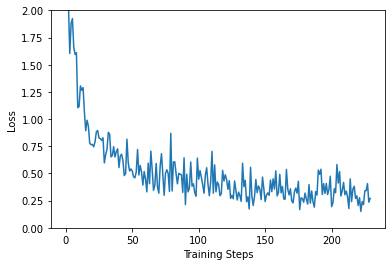

In [28]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

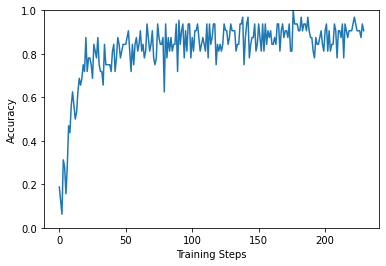

In [29]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [30]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

Run the image batch through the model and convert the indices to class names.

In [31]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the result

In [32]:
label_id = np.argmax(label_batch, axis=-1)

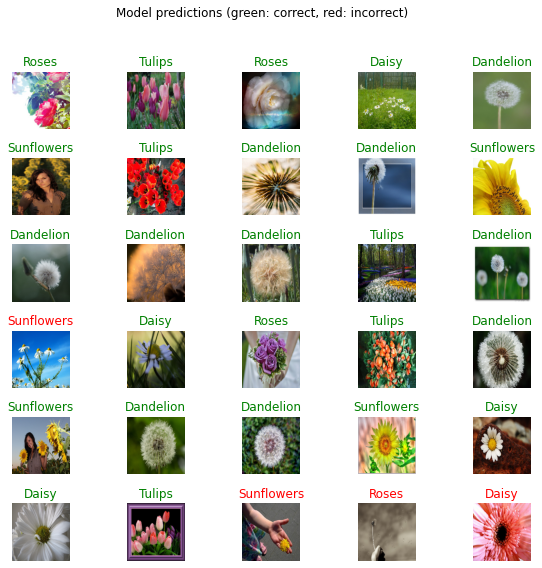

In [33]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Export your model

Now that you've trained the model, export it as a saved model:

In [34]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/saved_models/1589939013/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1589939013/assets


'/tmp/saved_models/1589939013'

Now confirm that we can reload it, and it still gives the same results:

In [35]:
reloaded = tf.keras.models.load_model(export_path)

In [36]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [37]:
abs(reloaded_result_batch - result_batch).max()

0.0

This saved model can be loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).
